# Function definitions

In [1]:
import pandas as pd
import os

from model_explorer.result_handling.collect_results import collect_results

def compute_energy(row):

    bits = row['parameters']
    energy_sum = 0.0
    i = 0
    bit_pairs = list(zip(bits[::2], bits[1::2]))

    for i, (w_bit, i_bit) in enumerate(bit_pairs):
        dfb = next(iter(energy_table[energy_table['layer_idx'] == i].index), 'no match')
        if dfb == 'no match':
            # print(f"no match on layer {i}")
            continue
        energy_row = energy_table.loc[[dfb]]

        energy_sum += energy_row['i_reads'].item() * energy_row['i_energy'].item() * (i_bit / 16)
        energy_sum += energy_row['w_reads'].item() * energy_row['w_energy'].item() * (w_bit / 16)

        if i > 0:
            energy_sum += energy_row['o_updates'].item() * energy_row['o_energy'].item() * (bit_pairs[i-1][1] / 16)
        else:
            energy_sum += energy_row['o_updates'].item() * energy_row['o_energy'].item() * (i_bit / 16)

    return energy_sum


def compute_memory_size(row):
    bits = row['parameters']
    byte = 0.0
    i = 0
    bit_pairs = list(zip(bits[::2], bits[1::2]))

    for i, (w_bit, i_bit) in enumerate(bit_pairs):
        dfb = next(iter(energy_table[energy_table['layer_idx'] == i].index), 'no match')
        if dfb == 'no match':
            continue
        energy_row = energy_table.loc[[dfb]]

        byte += energy_row['i_reads'].item() * (i_bit / 8)
        byte += energy_row['w_reads'].item() * (w_bit / 8)

        if i > 0:
            byte += energy_row['o_updates'].item() * (bit_pairs[i-1][1] / 8)
        else:
            byte += energy_row['o_updates'].item() * (i_bit / 8)

    return byte


def read_pickles(path):

    data = {}

    for i, file in enumerate(os.listdir(path)):
        if os.path.splitext(file)[1] != '.pkl':
            continue

        try:
            r = collect_results(os.path.join(path, file))
            fn = file.split('.')[0]
            fileparts = fn.split('_')

            df = r.to_dataframe()
            df[['acc']] = pd.DataFrame(df.accuracies.tolist(), index=df.index)
            df = df[df['acc'] > r.accuracy_limit]
            df['energy'] = df.apply(compute_energy, axis=1)
            df['size'] = df.apply(compute_memory_size, axis=1)
            
            data[i] = {
                'data' : df,
                'fileparts': fileparts
            }
                
        except Exception as inst:
            print(f"{file}: Skipping error: {inst.__str__()}")

    print(f"Found {len(data.items())} pickle files")

    return data


def read_baseline(file):
    r = collect_results(file)
    df_baseline = r.to_dataframe()
    df_baseline[['acc']] = pd.DataFrame(df_baseline.accuracies.tolist(), index=df_baseline.index)
    df_baseline = df_baseline[df_baseline['acc'] > r.accuracy_limit]
    df_baseline['energy'] = df_baseline.apply(compute_energy, axis=1)
    df_baseline['size'] = df_baseline.apply(compute_memory_size, axis=1)
    return df_baseline


B_TO_MB = 1_048_576


In [2]:
import numpy as np

def is_pareto_efficient_dumb(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def compute_pareto_points(df):
    df['acc_neg'] = -df['acc']
    points = df[['acc_neg', 'size']].to_numpy()
    # points = points
    pareto_array = is_pareto_efficient_dumb(points)
    pareto_array = np.expand_dims(pareto_array, 1)
    dout = np.hstack([points, pareto_array])
    return dout

def print_pareto_points(ndar, prefix):
    for row in ndar:
        domstr = prefix if row[2] == 0 else prefix + 'pareto'
        if row[2] == 0:
            continue
        print(f"{-row[0]:.4f},{row[1]/B_TO_MB:.4f},{domstr}")
    for row in ndar:
        domstr = prefix if row[2] == 0 else prefix + 'pareto'
        if row[2] == 1:
            continue
        print(f"{-row[0]:.4f},{row[1]/B_TO_MB:.4f},{domstr}")

### Fog on Deeplabv3+ with Fog

In [80]:
energy_file = '/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/dram_accesses_deeplabv3_mobilenetv2.csv'
energy_table = pd.read_csv(energy_file)

path = '/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/sweep_deeplab_mobilenet_fog'
baseline_path = '/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/expl_quantization_problem_deeplabv3_cityscapes_2023-05-06_15-05.pkl'

d_fog = read_pickles(path)
bl_fog = read_baseline(baseline_path)

compute_memory_size({'parameters': [2,4,5,6]})

Found 3 pickle files


32494993.5

Text(0.5, 1.0, 'Fog')

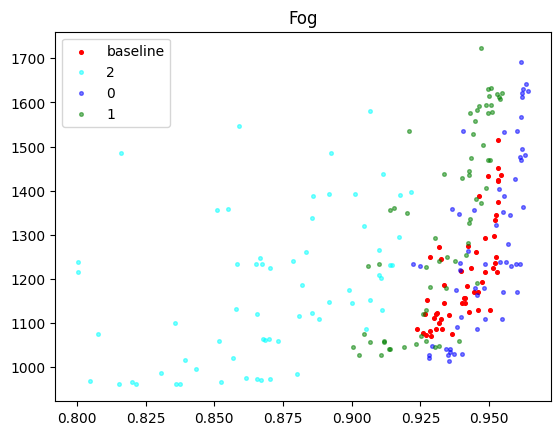

In [81]:
import matplotlib.pyplot as plt

ax = plt.gca()

clrs = {0: 'blue', 1: 'green', 2:'cyan'}

# ax.set_ylim((3000,7000))
# ax.set_xlim((0.69,0.98))
ax.scatter(bl_fog['acc'], bl_fog['size']/B_TO_MB, s=7, c='red', label='baseline')
for d in d_fog.values():
    ax.scatter(d['data']['acc'], d['data']['size']/B_TO_MB, alpha=0.5, s=7, c=clrs[int(d['fileparts'][3])], label=f'{d["fileparts"][3]}')
ax.legend()
ax.set_title(f"Fog")

In [110]:
for k,v in d_fog.items():
    print_pareto_points(compute_pareto_points(v['data']), v['fileparts'][3])

print_pareto_points(compute_pareto_points(bl_fog), 'bl')


0.8675,1233.6226,2
0.8508,1355.5017,2
0.8003,1238.0248,2
0.8006,1215.9535,2
0.8925,1485.1468,2
0.8550,1359.2780,2
0.8589,1546.6330,2
0.8582,1233.6197,2
0.8917,1391.7640,2
0.8856,1337.5161,2
0.8160,1486.1025,2
0.9067,1580.9256,2
0.9011,1392.5580,2
0.8788,1240.4073,2
0.8652,1232.8103,2
0.8858,1388.8863,2
0.8820,1186.0282,2
0.9115,1438.7861,2
0.8704,1224.1665,2
0.8668,1246.5226,2
0.9170,1295.4052,2pareto
0.8990,1175.8995,2
0.9044,1319.2860,2
0.9098,1264.8164,2
0.8305,986.2132,2
0.8077,1074.4567,2
0.8356,1099.5821,2
0.8215,962.7455,2
0.8657,1121.5326,2
0.8855,1122.1361,2
0.8835,1260.0191,2
0.9176,1390.7729,2pareto
0.8518,1059.8837,2
0.9052,1085.8728,2pareto
0.8392,1016.1128,2
0.9100,1209.0485,2
0.8377,961.0224,2pareto
0.8880,1110.2495,2
0.8579,1132.1744,2
0.8684,1061.8284,2
0.8568,1021.6426,2
0.8676,1063.9304,2
0.8919,1148.5381,2
0.8801,985.5322,2pareto
0.8047,968.2033,2
0.8432,996.8326,2
0.9110,1128.6320,2pareto
0.8615,975.4026,2
0.9148,1231.1224,2pareto
0.8699,1064.0867,2
0.9218,1396.678

### Rain

In [83]:
# unconstrained mobileNetv2
# path = '/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/sweep_deeplab_mobilenet'
# 5% deviation mobilenetv2
# path = '/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/sweep_deeplab_mobilenet_5percent'
# 5% deviation resnet101
energy_file = '/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/dram_accesses_deeplabv3_resnet101.csv'
energy_table = pd.read_csv(energy_file)

path = '/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/sweep_deeplab_resnet101'
baseline_path = '/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/sweep_deeplab_resnet101/baseline_resnet101_deeplab.bl_pkl'

d_deeplab_rain = read_pickles(path)
bl_deeplab_rain = read_baseline(baseline_path)


Found 36 pickle files


In [84]:
compute_memory_size({'parameters': [2,4,5,6]})

30436693.5

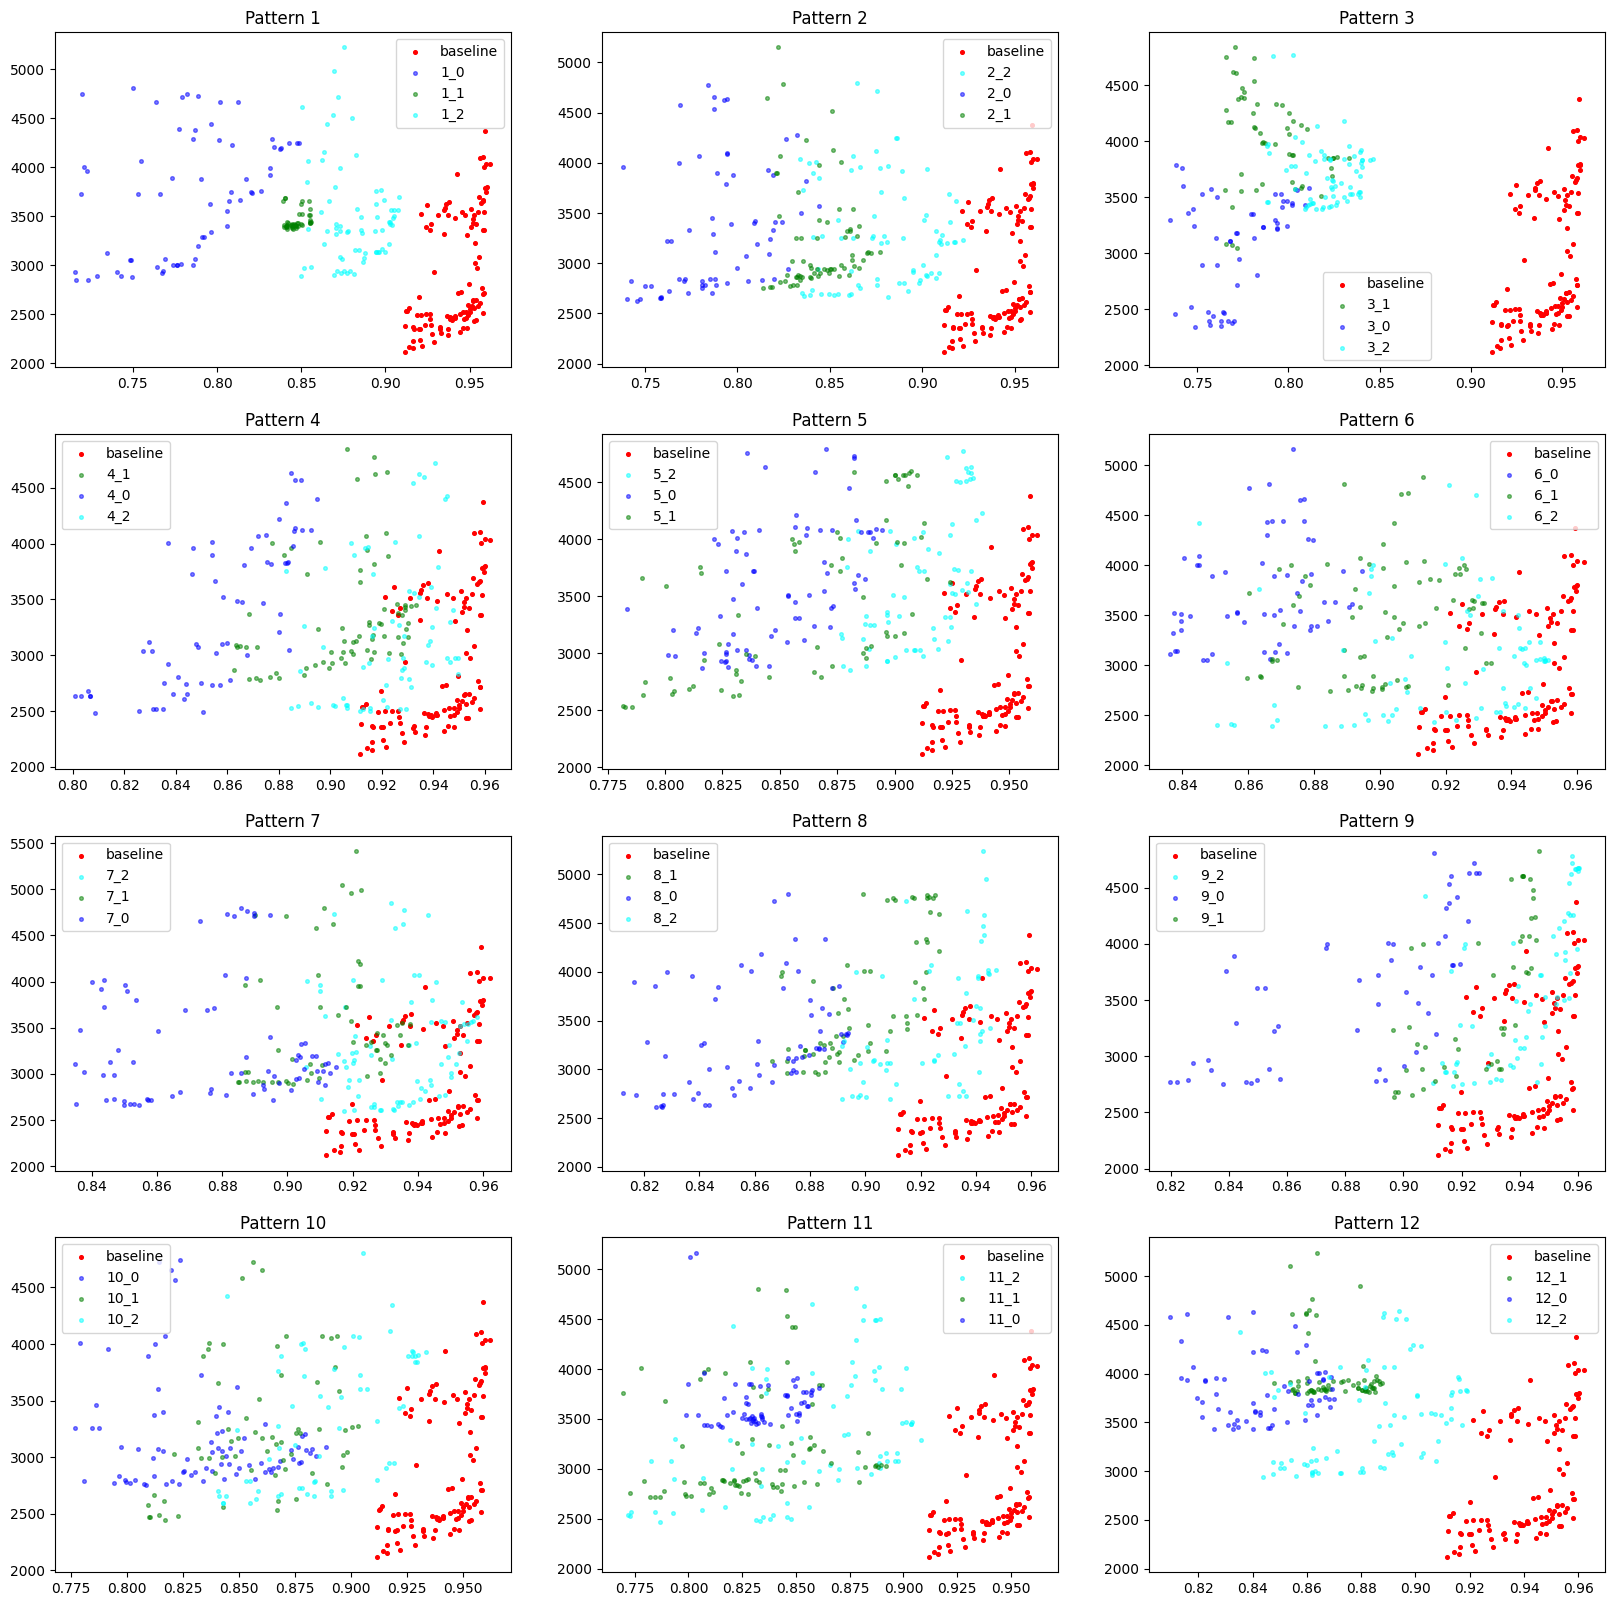

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,20))

clrs = {0: 'blue', 1: 'green', 2:'cyan'}
ax = ax.reshape(-1)

for i, a in enumerate(ax.reshape(-1)):
    # a.set_ylim((3000,7000))
    # a.set_xlim((0.69,0.98))
    a.scatter(bl_deeplab_rain['acc'], bl_deeplab_rain['size']/1_048_576, s=7, c='red', label='baseline')
    for d in d_deeplab_rain.values():
        if int(d['fileparts'][2]) == i + 1:
            a.scatter(d['data']['acc'], d['data']['size']/1_048_576, alpha=0.5, s=7, 
                      c=clrs[int(d['fileparts'][4])], 
                      label=f'{d["fileparts"][2]}_{d["fileparts"][4]}')
    a.legend()
    a.set_title(f"Pattern {i+1}")


In [113]:
# TikZ export

pattern = 9

for k,v in d_deeplab_rain.items():
    if v['fileparts'][2] == str(pattern):
        print_pareto_points(compute_pareto_points(v['data']), v['fileparts'][4])

print_pareto_points(compute_pareto_points(bl_deeplab_rain), 'bl')

# for k,v in d_deeplab_rain.items():
#     if v['fileparts'][2] == str(pattern):
#         for i, row in v['data'].iterrows():
#             print(f"{row['acc']}, {row['size']/B_TO_MB}, {v['fileparts'][4]}")

# for i, row in bl_deeplab_rain.iterrows():
#     print(f"{row['acc']}, {row['size']/B_TO_MB}, bl")

0.9477,3174.3434,2pareto
0.9523,3464.0822,2pareto
0.9597,3951.8449,2pareto
0.9551,3504.4977,2pareto
0.9202,2750.1938,2pareto
0.9473,2929.8276,2pareto
0.9298,2771.0713,2pareto
0.9571,3518.8260,2pareto
0.9244,2762.4170,2pareto
0.9605,4674.8289,2pareto
0.9171,2736.5420,2pareto
0.9572,3742.2716,2pareto
0.9458,2772.9973,2pareto
0.9600,4645.9063,2pareto
0.9488,3273.1263,2pareto
0.9472,3724.7728,2
0.9514,4067.2098,2
0.9377,4011.7568,2
0.9212,4001.6990,2
0.9163,3758.7577,2
0.9208,3960.6162,2
0.9074,4426.6201,2
0.9193,3279.5451,2
0.9182,2934.6503,2
0.9236,3268.2043,2
0.9601,4675.9568,2
0.9569,4542.2772,2
0.9580,4780.8539,2
0.9387,3490.0730,2
0.9576,4622.3081,2
0.9536,4143.5369,2
0.9393,3621.9425,2
0.9302,3023.8786,2
0.9428,3404.9288,2
0.9436,3465.8416,2
0.9565,4272.7212,2
0.9469,3720.6634,2
0.9524,3910.3786,2
0.9401,3071.7588,2
0.9581,4720.4151,2
0.9553,4199.4971,2
0.9134,2943.6454,2
0.9527,3526.5837,2
0.9592,4670.6134,2
0.9186,2945.6581,2
0.9142,2861.1873,2
0.9588,4666.8670,2
0.9572,4255.3326,

### YoloP with BDD100k

In [7]:
import sys
import os
sys.path.append('/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/model_explorer/third_party/yolop_det_seg')

energy_file = '/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/dram_accesses_yolop.csv'
energy_table = pd.read_csv(energy_file)

path = '/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/exploration_sweep_2023-05-08_16-47'
baseline_path = '/home/oq4116/projekte/ai-hardware-accelerators/mixed-precision-dnns/results/expl_quantization_problem_yolop_bdd100k_2023-05-08_12-52.pkl'

d_yolop = read_pickles(path)
bl_yolop = read_baseline(baseline_path)


Using cache found in /home/oq4116/.cache/torch/hub/hustvl_yolop_main


Found 2 pickle files


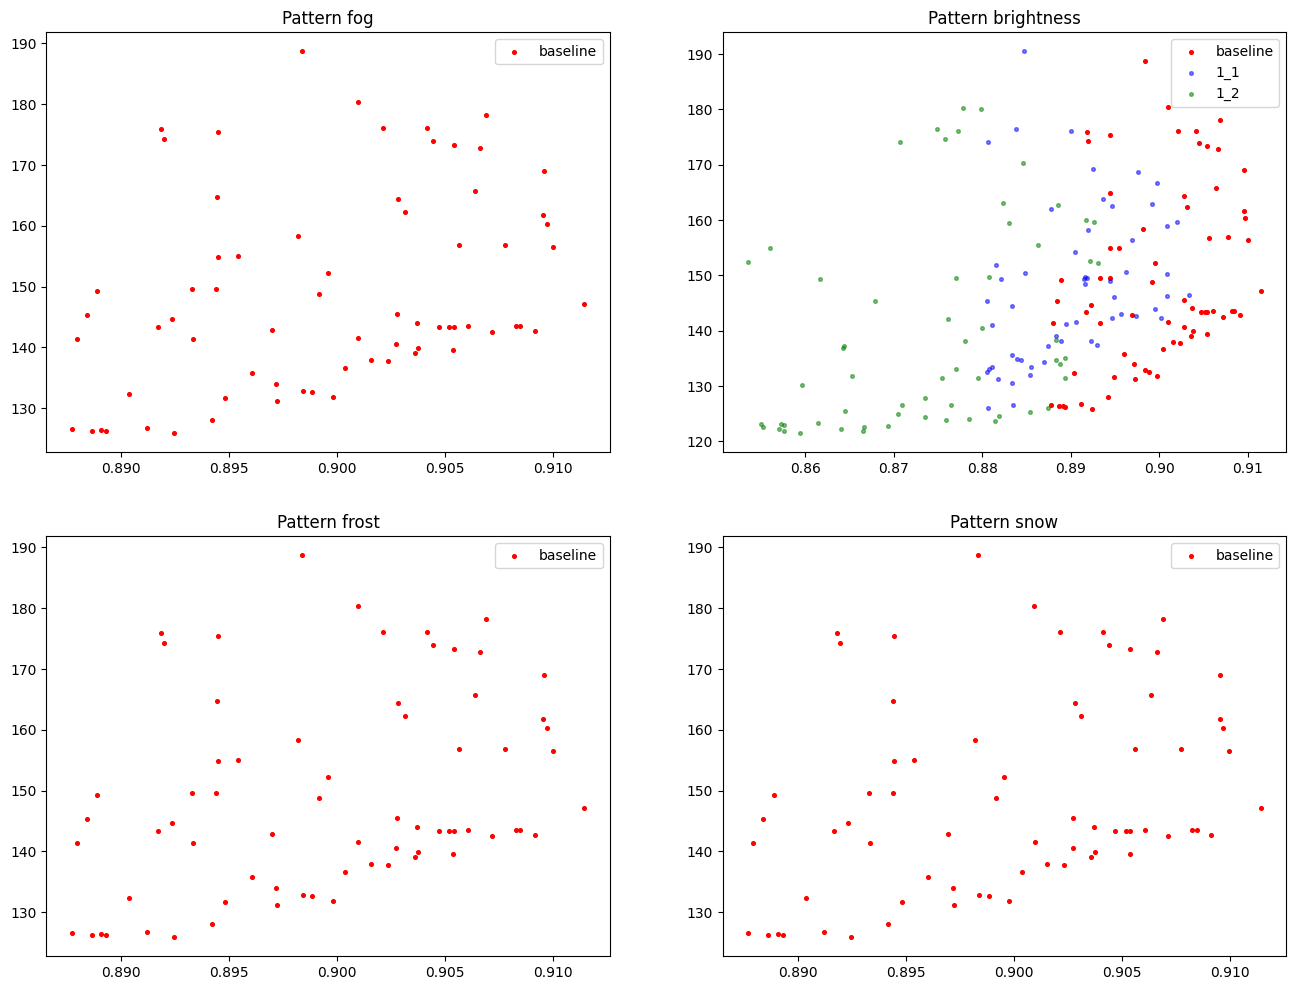

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12))

clrs = {0: 'blue', 1: 'green', 2:'cyan', 3: 'yellow', 4:'brown'}
ax = ax.reshape(-1)
conditions = {0: 'fog', 1:'brightness', 2:'frost',3:'snow'}

for i, a in enumerate(ax.reshape(-1)):
    # a.set_ylim((1500,5000))
    # a.set_xlim((0.69,0.98))
    a.scatter(bl_yolop['acc'], bl_yolop['size']/1_048_576, s=7, c='red', label='baseline')
    for d in d_yolop.values():
        if int(d['fileparts'][2]) == i:
            a.scatter(d['data']['acc'], d['data']['size']/1_048_576, alpha=0.5, s=7, 
                      c=clrs[int(d['fileparts'][4]) - 1], 
                      label=f'{d["fileparts"][2]}_{d["fileparts"][4]}')
    a.legend()
    a.set_title(f"Pattern {conditions[i]}")

In [10]:

pattern = 1
for k,v in d_yolop.items():
    if v['fileparts'][2] == str(pattern):
        print_pareto_points(compute_pareto_points(v['data']), v['fileparts'][4])

print_pareto_points(compute_pareto_points(bl_yolop), 'bl')

0.8834,126.5599,1pareto
0.8807,126.0720,1pareto
0.8855,133.5001,1pareto
0.8869,134.4235,1pareto
0.8946,142.2431,1pareto
0.9008,146.2003,1pareto
0.8853,132.0618,1pareto
0.8930,137.3481,1pareto
0.8874,137.2869,1pareto
0.9033,146.4590,1pareto
0.9002,142.3424,1pareto
0.8918,149.5384,1
0.8805,145.3846,1
0.8916,149.6634,1
0.8901,176.1112,1
0.8821,149.4237,1
0.8838,176.4365,1
0.8806,174.1702,1
0.8947,162.5688,1
0.8848,150.3622,1
0.8877,162.0079,1
0.8847,190.4660,1
0.8919,158.1755,1
0.8834,144.5310,1
0.8925,169.2287,1
0.8916,148.5158,1
0.8815,151.8265,1
0.8905,154.2496,1
0.8992,162.9727,1
0.8806,132.5944,1
0.8997,166.6626,1
0.8811,141.0389,1
0.8937,163.8271,1
0.8839,134.8164,1
0.8883,139.0669,1
0.8962,150.6549,1
0.8976,168.7206,1
0.8843,134.7947,1
0.8949,146.0900,1
0.8915,149.3349,1
0.8894,141.2468,1
0.8969,156.3635,1
0.9020,159.7130,1
0.9008,150.2744,1
0.8834,135.6869,1
0.8944,149.0254,1
0.8905,141.6700,1
0.8808,133.0440,1
0.8995,144.0017,1
0.8811,133.4845,1
0.8818,131.3544,1
0.8957,143.0497,